# Bayesian Optimization 

Bayesian optimization is useful for optimizing blackbox objective function, often function that are expensive to evalutate. 

###  Calibirating SWMM model with Baysian Optimization.
This example illustrates the calibration of the SWMM model using Baysian optimization. Calibration of swmm model based for a city is an involved process and involves a considerable amount of effort and experience. 

This is better than using GA to optimize the solution as it involves the same amount of work but effecient interms of the search. 

#### SWMM Model

In this example, we consider a storm water network of two ponds draining into a downstream channel, whose response is directed by the valve settings. These are a proxy for the parameters which would have to be calibrated in the swmm model.

#### Ground truth  

Ground truth in the swmm model is generated based on the synthetic rainflow and a random valve setting.

#### Objective funtion formulation 

Objective function is formulated such that the any deviation from the ground truth penalizes the agent.


In [1]:
## Import SWMM 
from pyswmm_lite import Env

In [1]:
## Import Scipack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {}

In [2]:
## Import Bayesian optimizaton pack
from GPyOpt.methods import BayesianOptimization

Generate the synth inflows for the network

In [3]:
# Generate sine waves
def generate_waves(window_len, cycles, magnitude = 1.0):
    half_wave = np.hstack((np.sin(np.linspace(0, 1.0, window_len)*np.pi),np.zeros([window_len]))) * magnitude
    flow = np.zeros([2*window_len*cycles])
    counter = 0
    for i in range(0, cycles):
        start_dim = counter
        end_dim = counter+(2*window_len)
        flow[start_dim:end_dim] = half_wave
        counter = counter+(2*window_len)
    return flow

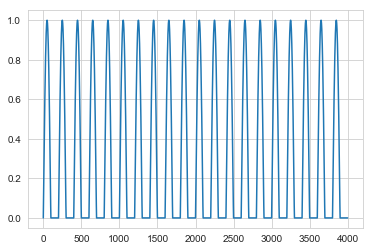

In [4]:
flow = generate_waves(100, 20, 1.0)
plt.plot(flow)

Generate the response of the watershed based on a random valve setting 

In [6]:
# Generate true signal based on a valve setting
env = Env("./parallel.inp")

data     = {}
act_flow = []
done     = False
flow     = generate_waves(100, 10, 1.0)
# target values 

valve_set1 = 0.30
valve_set2 = 0.70

for time in range(0, len(flow)):
    # set the gate_position 
    env.set_gate("1", valve_set1)
    env.set_gate("2", valve_set2)

    env.sim._model.setNodeInflow("P1", flow[time])
    env.sim._model.setNodeInflow("P2", flow[time])

    # record_data
    act_flow.append(env.flow("8"))

    # step through simulation
    done = env.step()

# terminate swmm
env.sim._model.swmm_end()
env.sim._model.swmm_close()

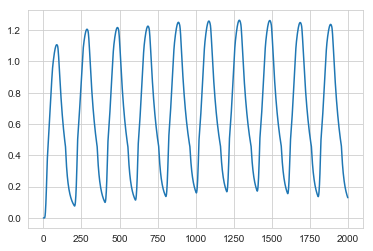

In [7]:
plt.plot(act_flow)

### Define Objective function

In [8]:
def run_swmm(valve_set1, valve_set2, flow):
    env = Env("./parallel.inp")
    obj_flow = []
    done = False
    for time in range(0, len(flow)):
        # set the gate_position 
        env.set_gate("1", valve_set1)
        env.set_gate("2", valve_set2)

        env.sim._model.setNodeInflow("P1", flow[time])
        env.sim._model.setNodeInflow("P2", flow[time])


        # record_data
        obj_flow.append(env.flow("8"))

        # step through simulation
        done = env.step()

    return obj_flow

# define swmm fun
def f(x):
    x1 = x[0][0]
    x2 = x[0][1]
    true_flow = np.asarray(act_flow)
    pred_flow = np.asarray(run_swmm(x1, x2, flow))
    loss = np.abs(true_flow.sum() - pred_flow.sum())
    return loss

In [9]:
# Define gpopt
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 0.5)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0, 1.0)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=f,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI',
        exact_feval = True,
        acquisition_weight = 2)

myBopt.run_optimization(max_iter=200)

In [10]:
 myBopt.x_opt

array([0.30157274, 0.70935042])

While the true values are 0.30 and 0.70

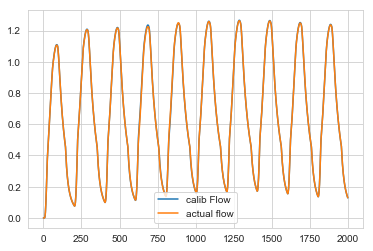

In [12]:
clalib_flow = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], flow)
plt.plot(clalib_flow, label = "calib Flow")
plt.plot(act_flow, label = "actual flow")
plt.legend()

Bayesian Optimization identifies the right solution within 200 tries. Which is amazinging!!